In [1]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img

## Load data & pre-proccessing

In [2]:
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'
sample_img = cv.imread('/kaggle/input/fer2013/train/happy/Training_80015.jpg', cv.IMREAD_GRAYSCALE)

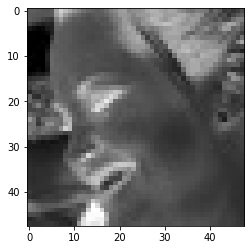

In [3]:
plt.figure(figsize=[4, 4])
plt.imshow(sample_img, cmap=plt.cm.gray_r)

In [4]:
def load_and_masking(src: str, mask: str):
    # load image
    array = cv.imread(src, cv.IMREAD_GRAYSCALE)

    # apply mask to image
    if mask == 'top':
        array[10:25] = 0
    else:
        array[30:] = 0

    return array


def prepare_dataset(src: str, dst: str, mask_on: str = 'top'):
    # create masked dataset
    for i, path in enumerate(os.listdir(src)):
        img_path = os.path.join(src, path)
        array = load_and_masking(img_path, mask_on)
        cv.imwrite(os.path.join(dst, path), array)

        print(f'{i + 1}/{len(os.listdir(src))}', end='\r')

In [5]:
if not os.path.isdir('./train'):
    os.mkdir('./train')

for cat in os.listdir(train_dir):
    src = os.path.join(train_dir, cat)
    dst = os.path.join('./train', cat)

    if not os.path.isdir(dst):
        os.mkdir(dst)

    prepare_dataset(src, dst)
    print()

3171/3171
4097/4097
3995/3995
4965/4965
4830/4830
436/436
7215/7215


In [6]:
if not os.path.isdir('./test'):
    os.mkdir('./test')

for cat in os.listdir(test_dir):
    src = os.path.join(test_dir, cat)
    dst = os.path.join('./test', cat)

    if not os.path.isdir(dst):
        os.mkdir(dst)

    prepare_dataset(src, dst)
    print()

831/831
1024/1024
958/958
1233/1233
1247/1247
111/111
1774/1774


## Model Building

### Configure

In [7]:
train_data_dir = './train'
epochs = 10
lr = 1e-4
valid_split = 0.2
input_size = 224
batch_size = 32
classes = 7
initializer = tf.keras.initializers.HeUniform()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
loss = tf.keras.losses.categorical_crossentropy

### Callbacks

In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=15,
                                              monitor='val_loss',
                                              restore_best_weights=True,
                                              verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=2,
                                                 monitor='val_loss',
                                                 factor=0.75,
                                                 verbose=1)

### Data Loder

In [9]:
generator = ImageDataGenerator(rescale=1 / 255,
                               rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               samplewise_center=True,
                               samplewise_std_normalization=True,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=valid_split)

In [10]:
train_datagen = generator.flow_from_directory(train_data_dir,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='training')

valid_datagen = generator.flow_from_directory(train_data_dir,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='validation')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


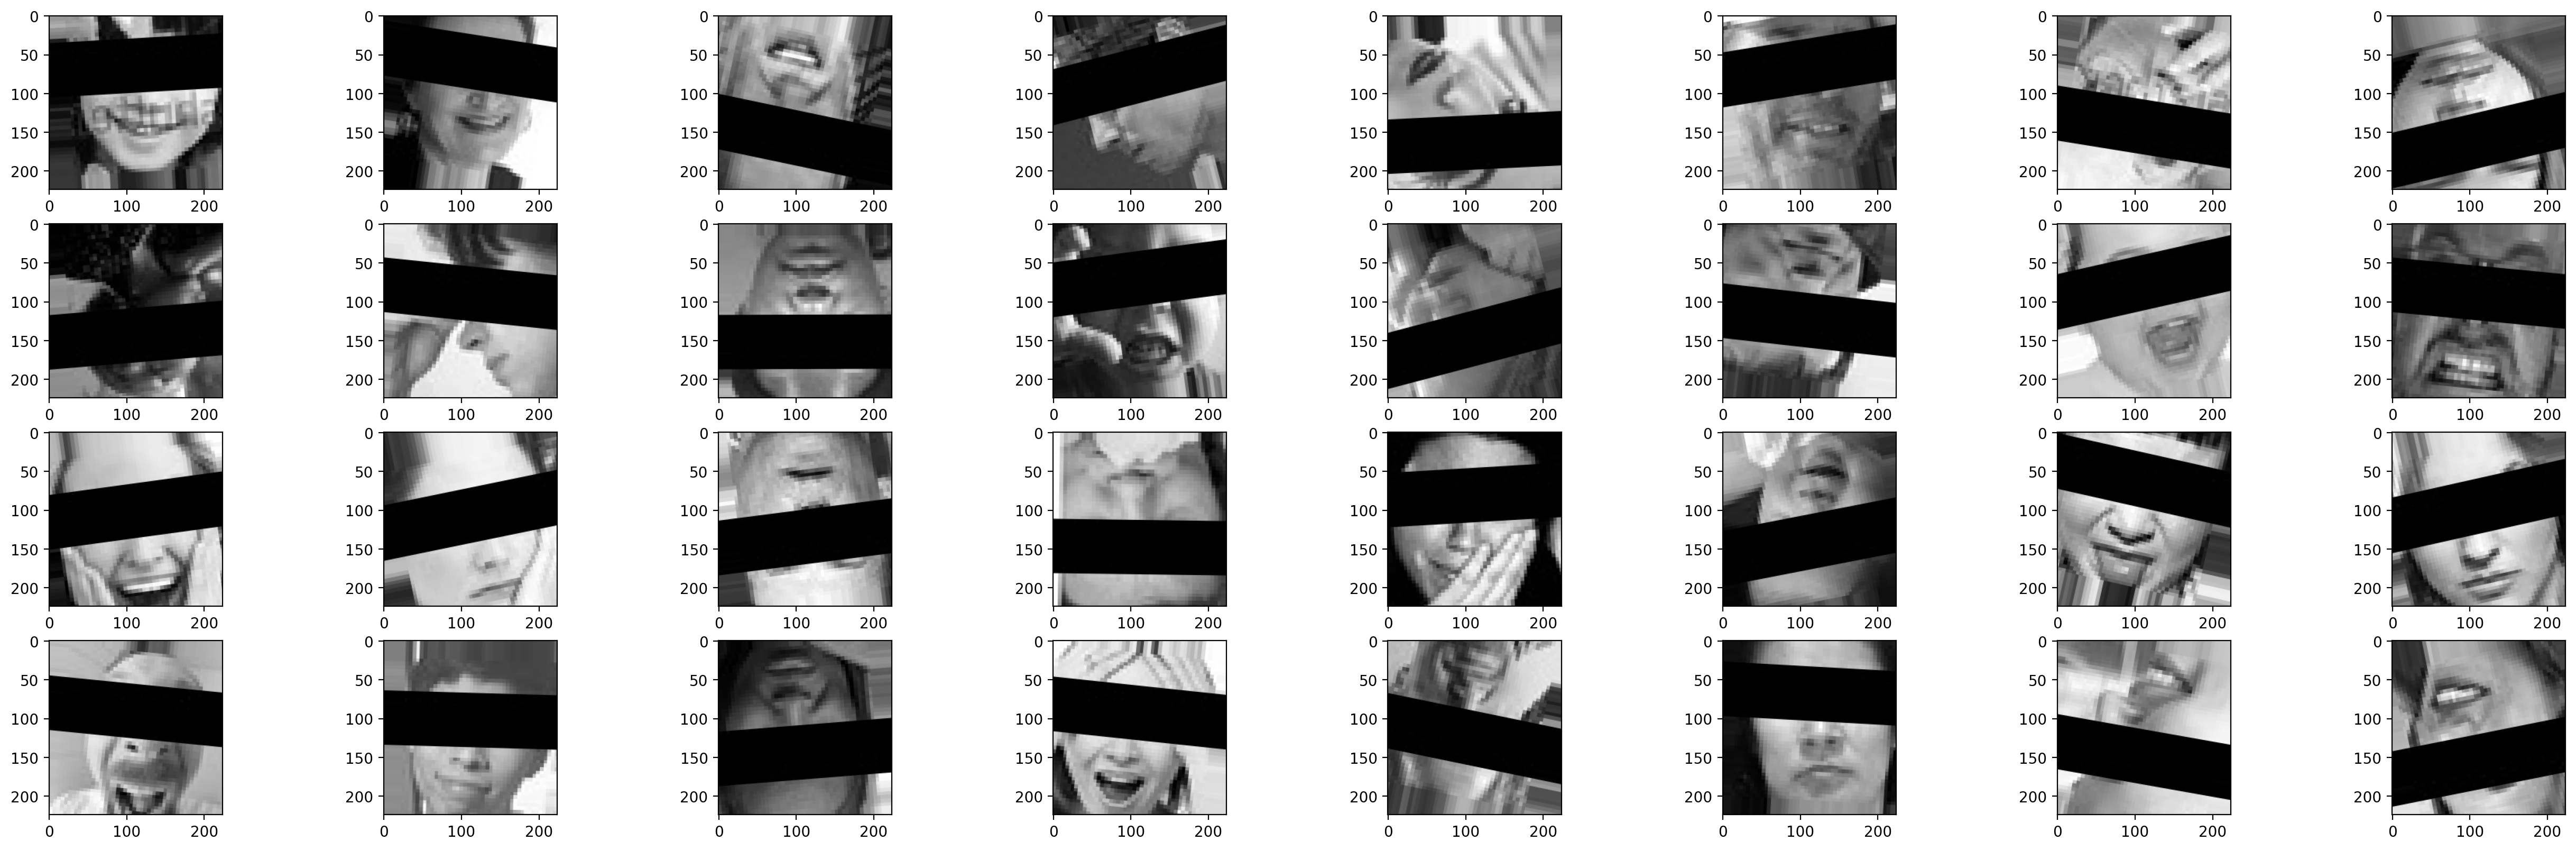

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=[32, 10], dpi=200)
axes = axes.ravel()

for i, arr in enumerate(train_datagen.next()[0]):
    img = array_to_img(arr)
    axes[i].imshow(img)

plt.show()

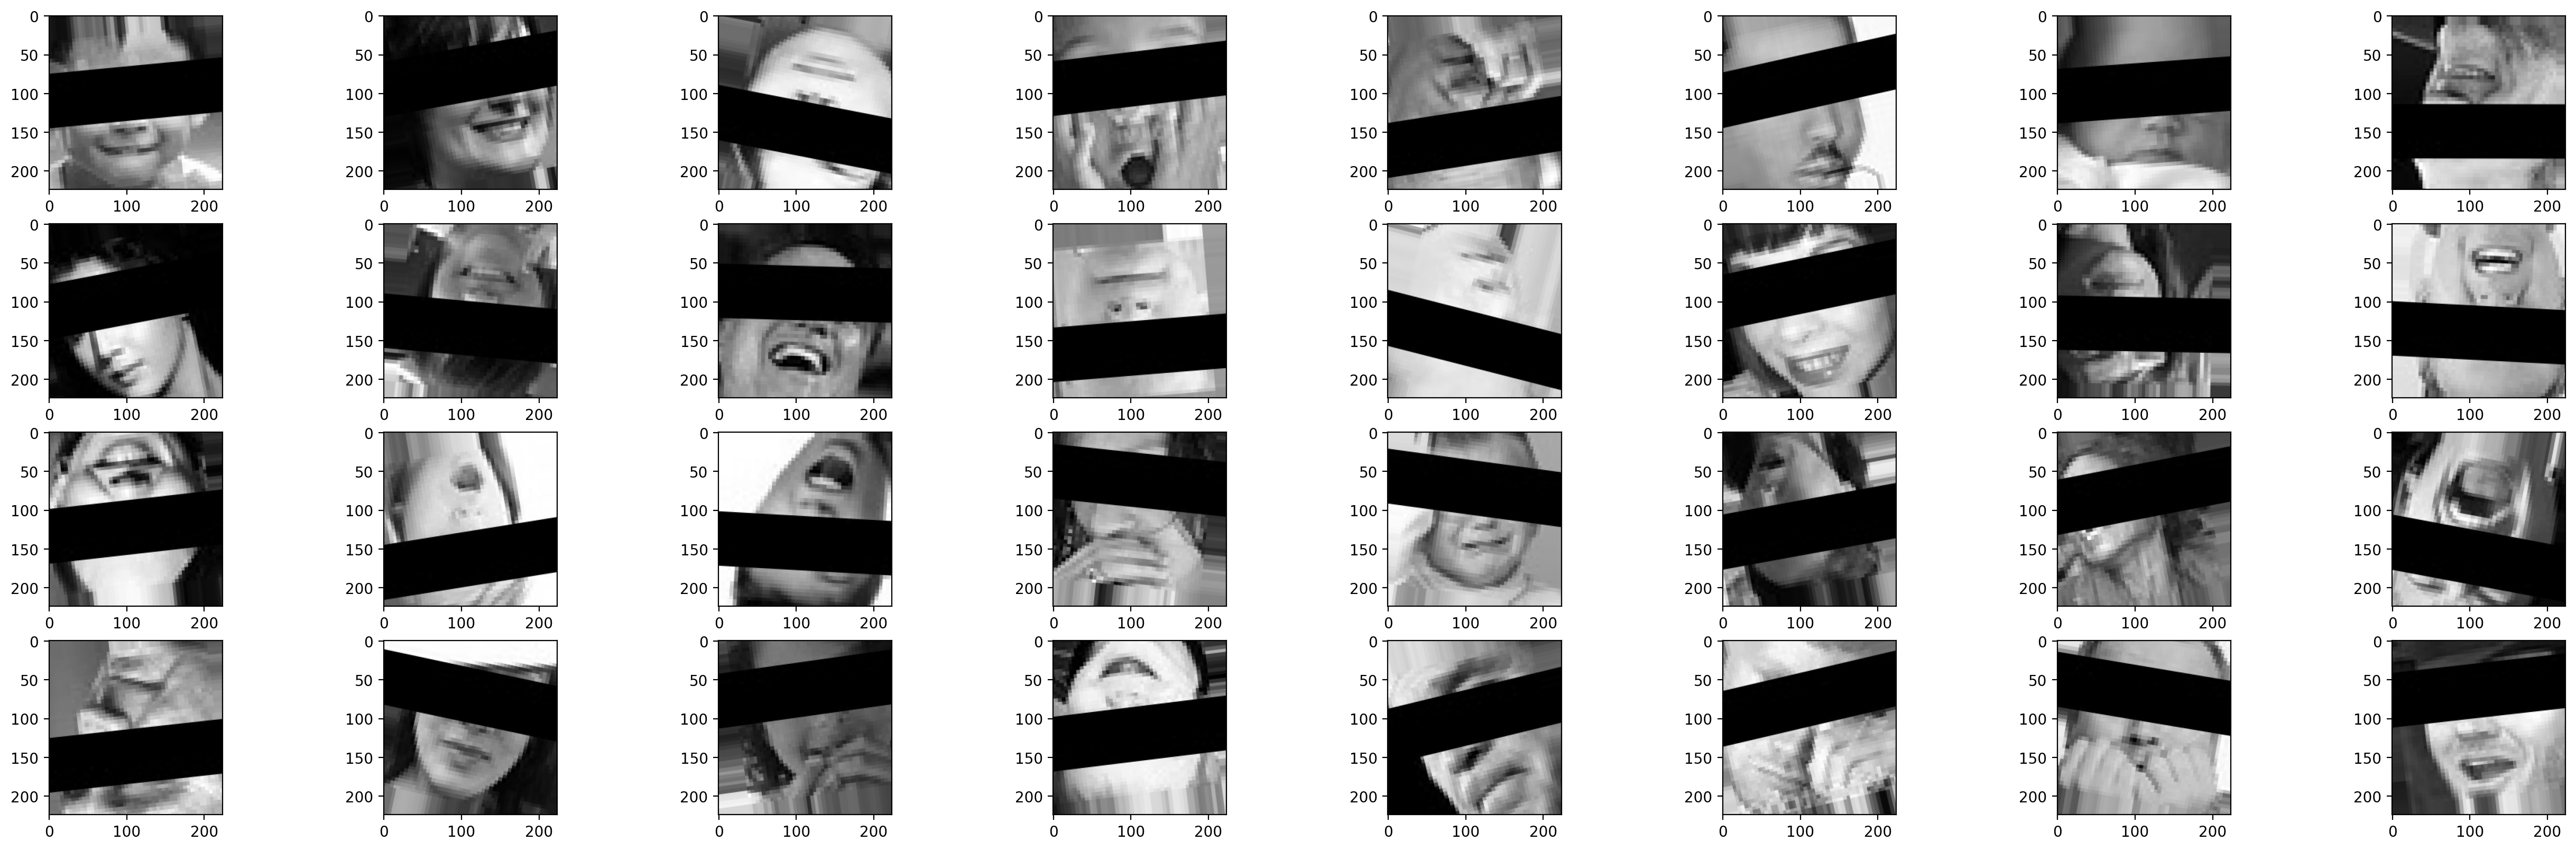

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=[32, 10], dpi=200)
axes = axes.ravel()

for i, arr in enumerate(valid_datagen.next()[0]):
    img = array_to_img(arr)
    axes[i].imshow(img)

plt.show()

### Model

In [13]:
input_ = layers.Input((input_size, input_size, 3))
back_bone = tf.keras.applications.MobileNetV2(include_top=False,input_tensor=input_, weights=None)

2022-12-08 15:46:31.912957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 15:46:31.913957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 15:46:32.206088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 15:46:32.206987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 15:46:32.207799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [14]:
model = Sequential([back_bone,
                    layers.AveragePooling2D((3, 3)),
                    layers.Flatten(),
                    layers.Dense(units=classes, activation=activations.softmax)])

### compilation

In [15]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_None (Funct (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d (AveragePo (None, 2, 2, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 35847     
Total params: 2,293,831
Trainable params: 2,259,719
Non-trainable params: 34,112
_________________________________________________________________


### training and validation

In [17]:
history = model.fit(train_datagen,
                    validation_data=valid_datagen,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[early_stop, reduce_lr])

2022-12-08 15:46:41.080949: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-12-08 15:46:54.650419: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


718/718 [==============================] - 411s 538ms/step - loss: 1.8502 - accuracy: 0.2252 - val_loss: 1.9430 - val_accuracy: 0.1730
Epoch 2/10
718/718 [==============================] - 389s 541ms/step - loss: 1.8210 - accuracy: 0.2404 - val_loss: 1.9341 - val_accuracy: 0.1427
Epoch 3/10
718/718 [==============================] - 387s 539ms/step - loss: 1.8000 - accuracy: 0.2537 - val_loss: 2.0481 - val_accuracy: 0.1427
Epoch 4/10
718/718 [==============================] - 386s 537ms/step - loss: 1.7715 - accuracy: 0.2774 - val_loss: 2.0187 - val_accuracy: 0.1427

Epoch 00004: ReduceLROnPlateau reducing learning rate to 7.499999810534064e-05.
Epoch 5/10
718/718 [==============================] - 388s 540ms/step - loss: 1.7297 - accuracy: 0.3009 - val_loss: 2.0852 - val_accuracy: 0.1104
Epoch 6/10
718/718 [==============================] - 387s 538ms/step - loss: 1.6923 - accuracy: 0.3241 - val_loss: 1.9540 - val_accuracy: 0.2513

Epoch 00006: ReduceLROnPlateau reducing learning rate